# Load gene sets and get score

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from pathlib import Path
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
NCEM_RES_DIR = Path("/Users/louis.kuemmerle/Promotion/projects/G1/from_Maiia/230922_ncem_results")
RES_DIR = "/Users/louis.kuemmerle/Promotion/projects/G1/results/spapros_smk_res"
DATA_DIR = "/Volumes/TOSHIBA_EXT/Promotion/data/G1/2022Fang_merfish"

In [3]:
# Define gene set scores in different ways

# We have two matrices per sample: test statistics and p-values
# each matrix has genes as index and cell-cell interaction pairs as columns

# score sum (over selected genes) of significant interactions per gene (argument: pval_th = 0.05 as default)

def gene_scores_nr_of_sign_interactions(pval_df, pval_th=0.05):
    """
    """
    df = (pval_df < pval_th)
    return (df.sum(axis=1) / df.sum().sum()).copy()    
    
def get_score(genes, df_gene_scores):
    """
    """
    return df_gene_scores.loc[genes].sum()


## Plot the highest interactions of Spapros genes that show variation for different types of interaction partners

In [5]:
# Ordered by the 5 samples
stats_files = [
    'ncem_tested_parms_H18.06.006.MTG.3491.expand.rep1.csv',
    'ncem_tested_parms_H18.06.006.MTG.3491.expand.rep2.csv',
    'ncem_tested_parms_H18.06.006.MTG.3491.expand.rep3.csv',
    'ncem_tested_parms_H22.26.401.MTG.3491.expand.rep1.csv',
    'ncem_tested_parms_H22.26.401.MTG.3491.expand.rep2.csv',
]
pval_files = [
    'ncem_fdr_pval_H18.06.006.MTG.3491.expand.rep1.csv',
    'ncem_fdr_pval_H18.06.006.MTG.3491.expand.rep2.csv',
    'ncem_fdr_pval_H18.06.006.MTG.3491.expand.rep3.csv',
    'ncem_fdr_pval_H22.26.401.MTG.3491.expand.rep1.csv',
    'ncem_fdr_pval_H22.26.401.MTG.3491.expand.rep2.csv',
]


In [6]:
# Get score for each gene set:

pval_dfs = [pd.read_csv(NCEM_RES_DIR / pval_files[b], index_col=0) for b in range(len(stats_files))]
test_stat_dfs = [pd.read_csv(NCEM_RES_DIR / stats_files[b], index_col=0) for b in range(len(stats_files))]

for df, dfp in zip(test_stat_dfs, pval_dfs):
    print(df.shape, dfp.shape)

# We exclude the first one as there are not all cell types present
pval_dfs = pval_dfs[1:]
test_stat_dfs = test_stat_dfs[1:]

dfs_score1 = [gene_scores_nr_of_sign_interactions(pval_df, pval_th=0.05) for pval_df in pval_dfs]


(3491, 324) (3491, 324)
(3491, 361) (3491, 361)
(3491, 361) (3491, 361)
(3491, 361) (3491, 361)
(3491, 361) (3491, 361)


In [7]:
# assert that all indices of dfs in dfs_scorex are the same
for dfs_ in [dfs_score1]:
    assert np.all([dfs_[0].index.tolist() == dfs_[i].index.tolist() for i in range(len(dfs_))])
    
# Aggregate scores over all samples
df_score1 = pd.concat(dfs_score1, axis=1).mean(axis=1)

#df_test_stat = pd.concat(test_stat_dfs, axis=1).mean(axis=1)
#df_pval = pd.concat(pval_dfs, axis=1).mean(axis=1)
# Mean over samples
n_dfs = len(test_stat_dfs)
df_test_stat = test_stat_dfs[0].copy()
df_pval = pval_dfs[0].copy()
for i in range(1, n_dfs):
    df_test_stat += test_stat_dfs[i]
    df_pval += pval_dfs[i]
df_test_stat /= n_dfs
df_pval /= n_dfs

# 
df_test_stat.columns = df_pval.columns

Spapros gene set

In [8]:
# load spapros selection with highest CCI score
df = pd.read_csv(Path(RES_DIR,"plot_tables","metrics_sn_and_merfish_bootstrap_cci.csv"),index_col=0)

In [9]:
selection_id = df.loc[["spapros" in i for i in df.index]].sort_values("(sp) CCI_n_interactions", ascending=False).index[1]

spapros_genes = pd.read_csv(Path(RES_DIR, "selection", selection_id+".csv"),index_col=0)#.index.tolist()
spapros_genes = spapros_genes.loc[spapros_genes.iloc[:,0]].index.tolist()

In [10]:
df_tmp = pd.DataFrame(index=df_score1.index, columns=["score1", "score3", "rank1", "rank3", "rank"])

df_tmp["score1"] = df_score1.values#loc[genes]
df_tmp["rank"] = df_tmp["score1"].rank(ascending=False)

df_tmp = df_tmp.sort_values("rank")
#df_tmp = df_tmp.loc[genes].sort_values("rank")

#### ncem plots

In [11]:
# Get variables for plotting functions
cell_names = df_pval.columns.to_series().apply(lambda x: x.split("_")[1].split(":")[0]).unique().tolist()
genes = df_pval.index.tolist()

qvalues = np.zeros((len(cell_names), len(cell_names), len(genes)))
fold_changes = np.zeros((len(cell_names), len(cell_names), len(genes)))

for r_idx, receiver in enumerate(cell_names):
    for s_idx, sender in enumerate(cell_names):
        qvalues[r_idx, s_idx, :] = df_pval.loc[genes, f"index_{receiver}:neighbor_{sender}"].values
        fold_changes[r_idx, s_idx, :] = df_test_stat.loc[genes, f"index_{receiver}:neighbor_{sender}"].values
        

In [12]:
from typing import Optional, List, Tuple

def sender_effect(
    receiver: str,
    cell_names: List[str],
    qvalues: np.ndarray,
    fold_change: np.ndarray,
    var_names: List[str],
    plot_mode: str = "fold_change",
    gene_subset: Optional[List[str]] = None,
    significance_threshold: float = 0.05,
    cut_pvals: float = -5,
    fontsize: Optional[int] = None,
    figsize: Tuple[float, float] = (6, 10),
    save: Optional[str] = None,
    suffix: str = "_sender_efect.pdf",
    show: bool = True,
):
    receiver_idx = cell_names.index(receiver)

    if fontsize:
        sc.set_figure_params(scanpy=True, fontsize=fontsize)

    if plot_mode == "qvals":
        arr = np.log(qvalues[receiver_idx, :, :].copy())
        arr[arr < cut_pvals] = cut_pvals
        df = pd.DataFrame(arr, index=cell_names, columns=var_names)
        if gene_subset:
            df = df.drop(index=receiver)[gene_subset]

        plt.ioff()
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        sns.heatmap(
            df.T, cbar_kws={"label": "$\log_{10}$ FDR-corrected pvalues"}, cmap="Greys_r", vmin=-5, vmax=0.0
        )
    elif plot_mode == "fold_change":
        arr = fold_change[receiver_idx, :, :].copy()
        arr[np.where(qvalues[receiver_idx, :, :] > significance_threshold)] = 0
        df = pd.DataFrame(arr, index=cell_names, columns=var_names)
        plt.ioff()
        if gene_subset:
            df = df.drop(index=receiver)[gene_subset]
        vmax = np.max(np.abs(df.values))

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        sns.heatmap(
            df.T,
            cbar_kws={"label": "$\log$ fold change", "location": "top"},
            cmap="seismic",
            vmin=-vmax,
            vmax=vmax,
        )
    plt.xlabel("sender cell type")
    plt.tight_layout()
    if save is not None:
        fig.savefig(save, bbox_inches="tight", transparent=True)
    if show:
        plt.show()
    plt.close(fig)
    plt.ion()

def receiver_effect(
    sender: str,
    cell_names: List[str],
    qvalues: np.ndarray,
    fold_change: np.ndarray,
    var_names: List[str],
    plot_mode: str = "fold_change",
    gene_subset: Optional[List[str]] = None,
    significance_threshold: float = 0.05,
    cut_pvals: float = -5,
    fontsize: Optional[int] = None,
    figsize: Tuple[float, float] = (6, 10),
    save: Optional[str] = None,
    suffix: str = "_receiver_efect.pdf",
    show: bool = True,
):
    sender_idx = cell_names.index(sender)

    if fontsize:
        sc.set_figure_params(scanpy=True, fontsize=fontsize)

    if plot_mode == "qvals":
        arr = np.log(qvalues[sender_idx, :, :].copy())
        arr[arr < cut_pvals] = cut_pvals
        df = pd.DataFrame(arr, index=cell_names, columns=data.celldata.var_names)
        if gene_subset:
            df = df.drop(index=sender)[gene_subset]

        plt.ioff()
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        sns.heatmap(
            df.T, cbar_kws={"label": "$\log_{10}$ FDR-corrected pvalues"}, cmap="Greys_r", vmin=-5, vmax=0.0
        )
    elif plot_mode == "fold_change":
        arr = fold_change[sender_idx, :, :].copy()
        arr[np.where(qvalues[:, sender_idx, :] > significance_threshold)] = 0
        df = pd.DataFrame(arr, index=cell_names, columns=var_names)
        plt.ioff()
        if gene_subset:
            df = df.drop(index=sender)[gene_subset]
        vmax = np.max(np.abs(df.values))

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        sns.heatmap(
            df.T,
            cbar_kws={"label": "$\log$ fold change", "location": "top"},
            cmap="seismic",
            vmin=-vmax,
            vmax=vmax,
        )
    plt.xlabel("receiver cell type")
    plt.tight_layout()
    if save is not None:
        fig.savefig(save, bbox_inches="tight", transparent=True)
    if show:
        plt.show()
    plt.close(fig)
    plt.ion()


def sender_receiver_effect_vulcanoplot(
    receiver: str,
    sender: str,
    cell_names: List[str],
    qvalues: np.ndarray,
    fold_change: np.ndarray,
    var_names: List[str],
    significance_threshold: float = 0.05,
    fold_change_threshold: float = 0.021671495152134755,
    fontsize: Optional[int] = None,
    figsize: Tuple[float, float] = (4.5, 7.0),
    save: Optional[str] = None,
    suffix: str = "_sender_receiver_volcanoplot.pdf",
    show: bool = True,
):
    receiver_idx = cell_names.index(receiver)
    sender_idx = cell_names.index(sender)

    min_pval = np.min(qvalues[qvalues > 0])
    qvalues = qvalues.copy()
    qvalues[qvalues == 0] = min_pval

    if fontsize:
        sc.set_figure_params(scanpy=True, fontsize=fontsize)
        plt.rcParams["axes.grid"] = False
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.grid(False)
    # only significant ones
    qval_filter = np.where(qvalues[receiver_idx, sender_idx, :] >= significance_threshold)
    vmax = np.max(np.abs(fold_change[receiver_idx, sender_idx, :]))
    # print(vmax)

    # overlaying significant ones with orange
    sns.scatterplot(
        x=fold_change[receiver_idx, sender_idx, :][qval_filter],
        y=-np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter],
        color="white",
        edgecolor="black",
        s=100,
        ax=ax,
    )

    qval_filter = np.where(qvalues[receiver_idx, sender_idx, :] < significance_threshold)
    x = fold_change[receiver_idx, sender_idx, :][qval_filter]
    fc_filter = np.where(x < fold_change_threshold)
    y = -np.nan_to_num(np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter])
    sns.scatterplot(x=x[fc_filter], y=y[fc_filter], color="darkgrey", edgecolor="black", s=100, ax=ax)

    x = fold_change[receiver_idx, sender_idx, :][qval_filter]
    fc_filter = np.where(x <= -fold_change_threshold)
    y = -np.nan_to_num(np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter], neginf=-14.5)
    sns.scatterplot(x=x[fc_filter], y=y[fc_filter], color="blue", edgecolor="black", s=100, ax=ax)

    x = fold_change[receiver_idx, sender_idx, :][qval_filter]
    fc_filter = np.where(x >= fold_change_threshold)
    y = -np.nan_to_num(np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter], neginf=-14.5)
    sns.scatterplot(x=x[fc_filter], y=y[fc_filter], color="red", edgecolor="black", s=100, ax=ax)

    ax.set_xlim((-vmax * 1.1, vmax * 1.1))
    # ax.set_ylim((-0.5, np.min([y[fc_filter], 15])))
    ax.set_xlabel("$\log$ fold change")
    ax.set_ylabel("$-\log_{10}$ FDR-corrected pvalues")
    
    plt.axvline(
        -fold_change_threshold,
        color="black",
        linestyle="--",
    )
    plt.axvline(
        fold_change_threshold,
        color="black",
        linestyle="--",
    )
    plt.axhline(-np.log10(significance_threshold), linestyle="--", color="black")

    plt.tight_layout()
    if save is not None:
        fig.savefig(save, bbox_inches="tight", transparent=True)
    if show:
        plt.show()
    plt.close(fig)
    plt.ion()


def vulcano_plot_ax(qvalues, fold_change, receiver_idx, sender_idx, ax, significance_threshold, fold_change_threshold, s, marker):
    """
    """
    # only significant ones
    qval_filter = np.where(qvalues[receiver_idx, sender_idx, :] >= significance_threshold)
    
    # overlaying significant ones with orange
    sns.scatterplot(
        x=fold_change[receiver_idx, sender_idx, :][qval_filter],
        y=-np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter],
        color="white",
        edgecolor="black",
        s=s,
        marker=marker,
        ax=ax,
    )        
    
    qval_filter = np.where(qvalues[receiver_idx, sender_idx, :] < significance_threshold)
    x = fold_change[receiver_idx, sender_idx, :][qval_filter]
    fc_filter = np.where(x < fold_change_threshold)
    y = -np.nan_to_num(np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter])
    sns.scatterplot(x=x[fc_filter], y=y[fc_filter], color="darkgrey", edgecolor="black", s=s, marker=marker, ax=ax)
    
    x = fold_change[receiver_idx, sender_idx, :][qval_filter]
    fc_filter = np.where(x <= -fold_change_threshold)
    y = -np.nan_to_num(np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter], neginf=-14.5)
    sns.scatterplot(x=x[fc_filter], y=y[fc_filter], color="blue", edgecolor="black", s=s, marker=marker, ax=ax)
    
    x = fold_change[receiver_idx, sender_idx, :][qval_filter]
    fc_filter = np.where(x >= fold_change_threshold)
    y = -np.nan_to_num(np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter], neginf=-14.5)
    sns.scatterplot(x=x[fc_filter], y=y[fc_filter], color="red", edgecolor="black", s=s, marker=marker, ax=ax)    



def multi_sender_receiver_effect_vulcanoplot(
    cell_names: List[str],
    qvalues: np.ndarray,
    fold_change: np.ndarray,
    receivers: Optional[List[str]] = None,
    senders: Optional[List[str]] = None,
    receiver_sender_pairs: Optional[List[Tuple[str, str]]] = None,
    genes: Optional[List[str]] = None,
    var_names: Optional[List[str]] = None,
    ncols: int = 4,
    significance_threshold: float = 0.05,
    fold_change_threshold: float = 0.021671495152134755,
    fontsize: Optional[int] = None,
    figsize_factor_xy: Tuple[float, float] = (2.75, 3.5),
    dotsizes: int = 30,
    dotsizes_genes: int = 100,
    save: Optional[str] = None,
    show: bool = True,
):
    if receiver_sender_pairs:
        n_plots = len(receiver_sender_pairs)
    elif receivers and senders:
        n_plots = len(receivers) * len(senders)
    else:
        raise ValueError("Either receiver_sender_pairs or receivers and senders need to be provided")
    nrows = n_plots // ncols + bool(n_plots % ncols)
    
    figsize = (figsize_factor_xy[0] * ncols, figsize_factor_xy[1] * nrows) 
    
    if not receiver_sender_pairs:
        receiver_sender_pairs = [(r, s) for r in receivers for s in senders]

    min_pval = np.min(qvalues[qvalues > 0])
    qvalues = qvalues.copy()
    qvalues[qvalues == 0] = min_pval

    if genes and var_names:
        genes_mask = np.array([g in genes for g in var_names])
        other_mask = np.array([g not in genes for g in var_names])
        #sizes = np.array([dotsizes_genes if g in genes else dotsizes for g in var_names])
        #markers = np.array(["*" if g in genes else "o" for g in var_names])
    else:
        genes_mask = np.array([False for _ in var_names])
        other_mask = np.array([True for _ in var_names])
        #sizes = np.array([dotsizes for _ in var_names])
        #markers = np.array(["o" for _ in var_names])


    if fontsize:
        sc.set_figure_params(scanpy=True, fontsize=fontsize)
        plt.rcParams["axes.grid"] = False
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize,)
    
    axs = axs.flatten()
    
    for i, ax in enumerate(axs):
        if i >= n_plots:
            ax.axis("off")
            continue
        
        plt.sca(ax)
        
        receiver, sender = receiver_sender_pairs[i]
        
        receiver_idx = cell_names.index(receiver)
        sender_idx = cell_names.index(sender)
    
        ax.grid(False)
        
        vmax = np.max(np.abs(fold_change[receiver_idx, sender_idx, :]))
        
        for s, marker, mask in zip([dotsizes, dotsizes_genes], ["o","*"], [other_mask, genes_mask]):
            if np.any(mask):
                qvalues_tmp = qvalues[:, :, mask].copy()
                fold_change_tmp = fold_change[:, :, mask].copy()
        
                vulcano_plot_ax(
                    qvalues_tmp, fold_change_tmp, receiver_idx, sender_idx, ax, 
                    significance_threshold, fold_change_threshold, s, marker
                )
        
        ## only significant ones
        #qval_filter = np.where(qvalues[receiver_idx, sender_idx, :] >= significance_threshold)
        #
        ## print(vmax)
    #
        ## overlaying significant ones with orange
        #sns.scatterplot(
        #    x=fold_change[receiver_idx, sender_idx, :][qval_filter],
        #    y=-np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter],
        #    color="white",
        #    edgecolor="black",
        #    s=sizes[qval_filter],
        #    marker=markers[qval_filter],
        #    #s=dotsizes,
        #    ax=ax,
        #)        
    #
        #qval_filter = np.where(qvalues[receiver_idx, sender_idx, :] < significance_threshold)
        #x = fold_change[receiver_idx, sender_idx, :][qval_filter]
        #fc_filter = np.where(x < fold_change_threshold)
        #y = -np.nan_to_num(np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter])
        #sns.scatterplot(
        #    x=x[fc_filter], y=y[fc_filter], color="darkgrey", edgecolor="black", #s=100, 
        #    sizes=sizes[qval_filter][fc_filter], markers=markers[qval_filter][fc_filter], ax=ax
        #)
    #
        #x = fold_change[receiver_idx, sender_idx, :][qval_filter]
        #fc_filter = np.where(x <= -fold_change_threshold)
        #y = -np.nan_to_num(np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter], neginf=-14.5)
        #sns.scatterplot(x=x[fc_filter], y=y[fc_filter], color="blue", edgecolor="black", s=100, ax=ax)
    #
        #x = fold_change[receiver_idx, sender_idx, :][qval_filter]
        #fc_filter = np.where(x >= fold_change_threshold)
        #y = -np.nan_to_num(np.log10(qvalues[receiver_idx, sender_idx, :])[qval_filter], neginf=-14.5)
        #sns.scatterplot(x=x[fc_filter], y=y[fc_filter], color="red", edgecolor="black", s=100, ax=ax)
    
        ax.set_title(f"{receiver} - {sender}")
        ax.set_xlim((-vmax * 1.1, vmax * 1.1))
        # ax.set_ylim((-0.5, np.min([y[fc_filter], 15])))
        if i >= n_plots - ncols:
            ax.set_xlabel("$\log$ fold change")
        if i % ncols == 0:
            ax.set_ylabel("$-\log_{10}$ FDR-corrected pvalues")
        
        plt.axvline(
            -fold_change_threshold,
            color="black",
            linestyle="--",
        )
        plt.axvline(
            fold_change_threshold,
            color="black",
            linestyle="--",
        )
        plt.axhline(-np.log10(significance_threshold), linestyle="--", color="black")

    #plt.tight_layout()
    if save is not None:
        fig.savefig(save, bbox_inches="tight", transparent=True)
    if show:
        plt.show()
    plt.close(fig)
    plt.ion()



In [13]:
# Get df for plotting (rank receiver sender pairs)

significance_threshold = 0.05
fold_change_threshold = 0.021671495152134755,

receiver_sender_pairs = [[r, s] for r in cell_names for s in cell_names]
rs_df = pd.DataFrame(index=[f"{r} - {s}" for r, s in receiver_sender_pairs], columns=["receiver","sender","n sign spapros", "n sign", "sign"])

spapros_mask = np.array([g in spapros_genes for g in genes])
#spapros_idxs = np.where(spapros_filter)[0]

idxs = {}

for receiver in cell_names:
    for sender in cell_names:
        rs_df.loc[f"{receiver} - {sender}", "receiver"] = receiver
        rs_df.loc[f"{receiver} - {sender}", "sender"] = sender
        #print(receiver, sender)
        receiver_idx = cell_names.index(receiver)
        sender_idx = cell_names.index(sender)
        qval_mask = qvalues[receiver_idx, sender_idx, :] < significance_threshold
        fc_mask = np.abs(fold_changes[receiver_idx, sender_idx, :]) > fold_change_threshold
        mask = qval_mask & fc_mask
        spapros_mask_rs = mask & spapros_mask
        #qval_filter = np.where(qvalues[receiver_idx, sender_idx, :] < significance_threshold)
        #x = fold_changes[receiver_idx, sender_idx, :][qval_filter]
        #fc_filter = np.where(np.abs(x) > fold_change_threshold)
        
        rs_df.loc[f"{receiver} - {sender}", "n sign spapros"] = np.sum(spapros_mask_rs)
        rs_df.loc[f"{receiver} - {sender}", "n sign"] = np.sum(mask)
        rs_df.loc[f"{receiver} - {sender}", "sign"] = np.any(mask)
        #rs_df.loc[f"{receiver} - {sender}", "n sign spapros"] = len([g_idx for g_idx in fc_filter[0] if g_idx in spapros_idxs])
        #rs_df.loc[f"{receiver} - {sender}", "n sign"] = len(fc_filter[0])
        #rs_df.loc[f"{receiver} - {sender}", "sign"] = len(fc_filter[0]) > 0
        
        idxs[f"{receiver} - {sender}"] = spapros_mask_rs
        
rs_df["ratio"] = 0
sign = rs_df["sign"].values
rs_df.loc[sign,"ratio"] = rs_df.loc[sign,"n sign spapros"] / rs_df.loc[sign,"n sign"]
        
        #if np.any(fc_filter):
        #    receiver_sender_pairs.append((receiver, sender))
        #    #print(receiver, sender, x[fc_filter])
        #else:
        #    print("no genes")

In [14]:
(rs_df["n sign"] == 0).value_counts()

n sign
False    267
True      94
Name: count, dtype: int64

In [15]:
(rs_df.loc[rs_df["sign"], "n sign spapros"] > 0).value_counts()



n sign spapros
True     225
False     42
Name: count, dtype: int64

In [ ]:
# --> 225 / (225+42) = 0.84 
# --> we have significant genes for 84% of possible cell cell interaction cell type pairs

In [16]:

from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
SMALL_SIZE = 9  # 17
MEDIUM_SIZE = 11  # 19
BIGGER_SIZE = 13  # 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

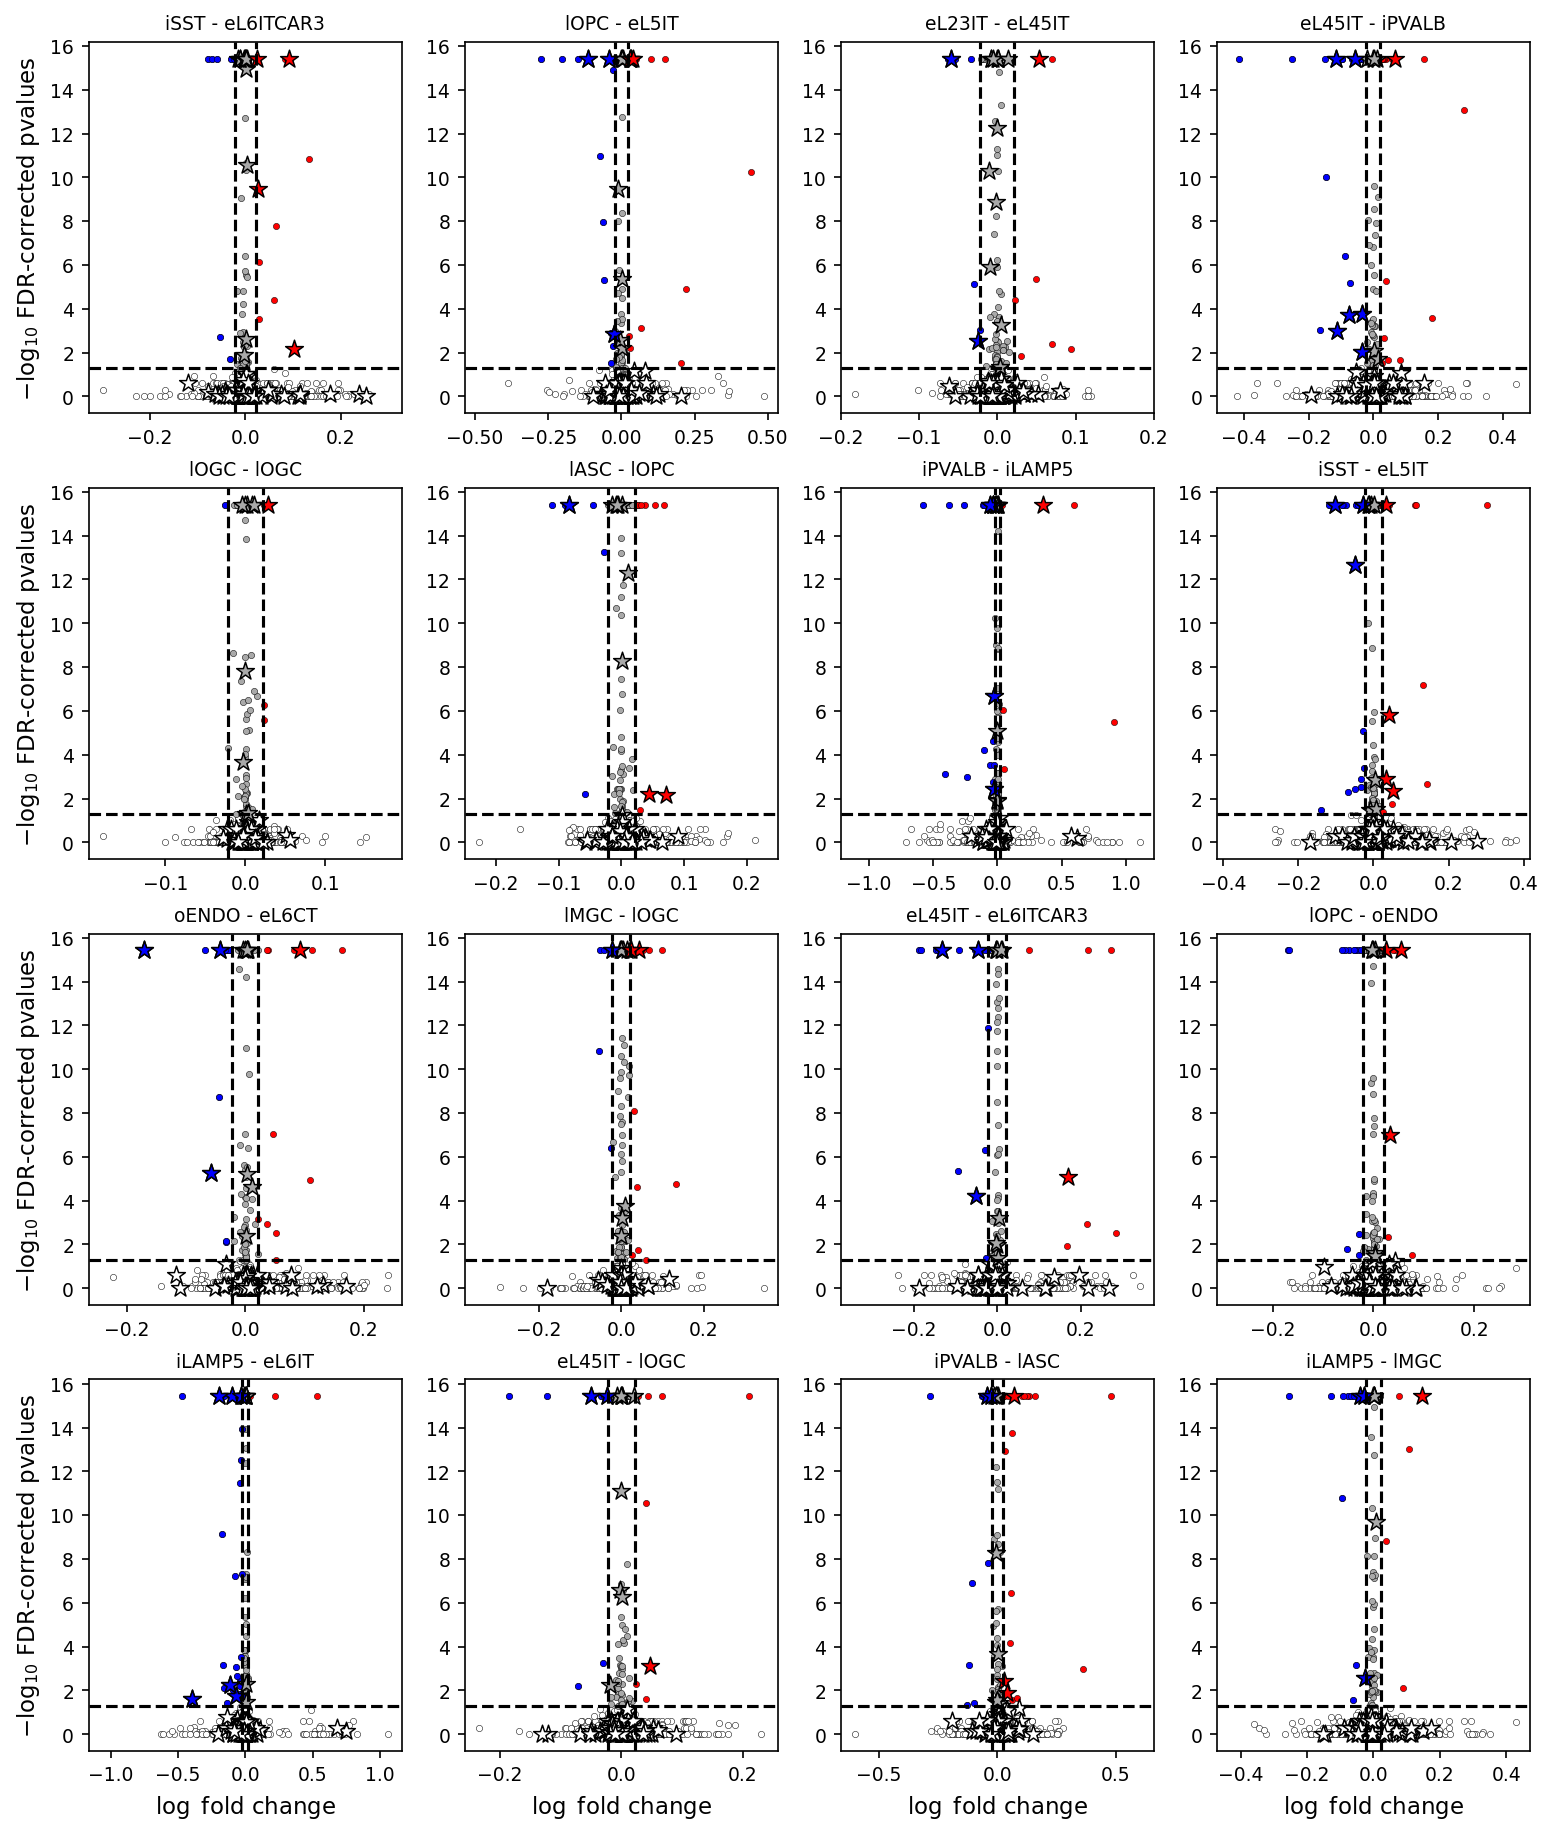

In [18]:
# plot the 16 highest ratios

multi_sender_receiver_effect_vulcanoplot(
    #receivers=cell_names[:7],
    #senders=cell_names[:7],
    receiver_sender_pairs=rs_df.sort_values("ratio", ascending=False)[["receiver","sender"]].values[:16].tolist(),
    cell_names=cell_names,
    qvalues=qvalues,
    fold_change=fold_changes,
    var_names=genes,
    genes=spapros_genes,
    dotsizes=9,
    dotsizes_genes=80,
    figsize_factor_xy=(3.1, 3.7),
    save="./figures/NCEM_sender_receiver_volcanoplot_spapros_genes.pdf",
    #ncols: int=4,
    #significance_threshold: float=0.05,
    #fold_change_threshold: float=0.021671495152134755,
    #fontsize: Optional[int]=None,
    #figsize_factor_xy: Tuple[float, float]=(2.75, 3.5),
    #save: Optional[str]=None,
    #show: bool=True,
)
